### Visualisation and analysis of `classify-classifications.csv`.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dateutil.parser import parse
from datetime import date
from datetime import datetime

import sys
sys.path.append('../..')
from sf_lib.df import make_df_classify, make_df_tasks_with_props, make_df_vote_threshold, make_df_task0

%matplotlib inline

In [2]:
# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf_lib
reload(sf_lib)

<module 'sf_lib' from '../..\\sf_lib\\__init__.py'>

In [129]:
# set matplotlib plotting params:
font = {
    'family': 'Verdana',
    'weight': '300',
    'size': 10
}

rc('font', **font)

def legend_grid_show(fr, savepath):
    '''
    Shorthand to render basic legend and grid
    '''
    fr.legend()
    fr.grid(alpha=0.3, which='both')
    
    if savepath:
        plt.savefig('{}.png'.format(savepath), dpi=350)
    plt.show()

## Load parsed dataframes

In [4]:
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")
candidate_names_classify = np.loadtxt('../sf_candidate_names__classification-classify.txt', dtype='str')
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')
answer_types = ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']

In [5]:
df = make_df_classify()
df_votes = make_df_tasks_with_props(df, candidate_names_classify, object_info)

# Inspect vote count per object

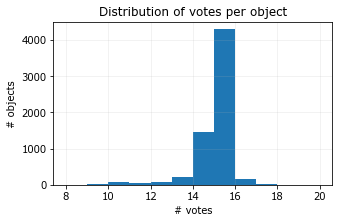

In [6]:
gr_by_name = df.groupby(['Filename'])
groups = list(gr_by_name.groups)

vote_counts = list(df_votes['# votes'])  # Extract vote count:

# Plot histogram of votes per object:
fig, fr = plt.subplots(figsize=(5,3))

bins = list(range(int(min(vote_counts)), int(max(vote_counts))+1))
fr.hist(vote_counts, bins=bins)
fr.grid(alpha=0.2, which='both')
fr.update({
    'xlabel': '# votes',
    'ylabel': '# objects',
    'title': 'Distribution of votes per object',
})

plt.show()

### Extract the occurrence rate of every `# votes` value:

In [7]:
def count_dict(entries):
    '''
    @params: entries: list of vals
    @returns: dictionary where the keys are the vals, and the values are the number of times each val occurs in entries
    '''
    count_dict = {}
    
    for key in set(entries):
        count_dict[key] = entries.count(key)
        
    return count_dict

In [8]:
count_dict(vote_counts)  # uncomment to inspect vote count occurrence rate

{8.0: 2,
 9.0: 13,
 10.0: 64,
 11.0: 63,
 12.0: 72,
 13.0: 217,
 14.0: 1454,
 15.0: 4289,
 16.0: 165,
 17.0: 12,
 18.0: 5,
 19.0: 3,
 20.0: 3}

## Plot vote distributions

Since it's tough to get a good look at all the images from the project in a short timeframe, let's inspect the overall distribution of votes to get a feel for the data.

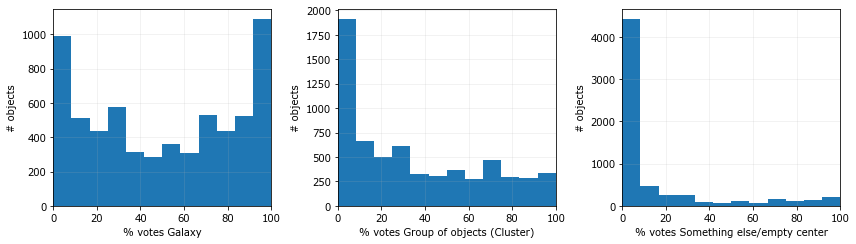

In [56]:
fields = ['% votes {}'.format(ans) for ans in answer_types]

fig, fr = plt.subplots(1,len(fields), figsize=(12, 3.5))

for idx, field in enumerate(fields):
    fr[idx].hist(df_votes[field], bins=12)

    fr[idx].grid(alpha=0.2, which='both')
    fr[idx].update({
        'xlabel': field,
        'ylabel': '# objects',
        'xlim': [0,100]
    })
    
fig.tight_layout()

plt.savefig('classify raw percentages.png', dpi=350)
plt.show()

Of note: 
- vote distribution for `galaxy` is a relatively two-sided distribution. Most likely are basically either 'definitely not a galaxy' and 'definitely a galaxy'.
    Looking at this distribution, a naive first approximation for 'certainty' in the people's vote might be, say, 75% votes for `galaxy`.
- votes distribution for `cluster` is mostly 'no', but there are still plenty of objects where people do vote for `cluster`
- relatively few objects are supposedly `empty` or `something else`

Examine 'Task 1' results. 
- If task 0 answer is `galaxy`, task 1 asks "Is the galaxy fluffy or is it bright?"

In [59]:
# find classifications where people voted 'galaxy'. filter out those where they didn't cast a vote for T1 as the classification then isn't useful
galaxy_classifications = df[['T0', 'T1']][(df['T0'] == 'Galaxy') & (~df['T1'].isnull())]

print(galaxy_classifications['T1'].value_counts())  # count of 'Fluffy' and 'Bright'

16554/(16554+29792), 29792/(16554+29792), (16554+29792)

Fluffy    29792
Bright    16554
Name: T1, dtype: int64


(0.3571829284080611, 0.6428170715919389, 46346)

## Plot % votes galaxy vs. % fluffy/bright

In [11]:
objects_with_galaxy_classifications = df_votes[df_votes['% votes Galaxy'] > 0]
objects_with_galaxy_classifications.head(3)

,name,% Fluffy,% Bright,% None,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center,RA,...,ge,re,ie,Reffe,r_mage,ne,C,mue_r,bae,RFF
0,UDGcand_5199,100.0,0.0,0.0,"{'Galaxy': 7, 'Group of objects (Cluster)': 8}",15.0,46.7,53.3,0.0,52.230835,...,0.125836,0.080158,0.058179,0.467015,0.227145,0.179743,3.615518,24.609257,0.041523,-99.0
1,UDGcand_3665,11.1,88.9,0.0,"{'Galaxy': 9, 'Something else/empty center': 2...",15.0,60.0,26.7,13.3,55.146099,...,0.312619,0.085179,0.047292,0.375001,0.216963,0.173415,2.821357,24.523552,0.040093,-99.0
2,UDGcand_5395,66.7,33.3,0.0,{'Galaxy': 15},15.0,100.0,0.0,0.0,51.570633,...,0.063627,0.036937,0.040684,0.274450,0.084980,0.083370,2.685596,22.771971,0.019588,-99.0


## Inspect the votes for objects that are in the post-selection catalogue:

In [12]:
def filterby_in_catalogue(df, catalogue, in_catalogue_bool):
    '''
    @param df: should be a version of df_votes
    @param catalogue: list of objects in catalogue, from sf_catalogue_targets.txt
    @param {boolean} in_catalogue_bool: specify whether we want objects in or not in catalogue
    '''

    if in_catalogue_bool:
        return df[df['name'].isin(catalogue)]
    else:
        return df[~df['name'].isin(catalogue)]

In [13]:
def plot_galaxy_and_cluster_votes(fr, idx, filtered_df, title):
    '''
    @param filtered_df: response from filterby_in_catalogue
    @param fr: matplotlib plot
    @param {int} idx: fr index
    @param {string} title: plot title
    '''
    # plot histograms of vote distribution for the objects in the catalogue
    fr[idx].hist(filtered_df['% votes Group of objects (Cluster)'], alpha=0.6, label='Cluster', density=True)
    fr[idx].hist(filtered_df['% votes Galaxy'], alpha=0.75, label='Galaxy', density=True)

    fr[idx].update({
        'xlabel': '% votes',
        'ylabel': 'normed # objects',
        'xlim': [0,100],
        'title': title,
    })
    fr[idx].grid(alpha=0.2, which='both')
    fr[idx].legend()
    
def make_single_plot_galaxy_cluster(dfs, titles):
    fig, fr = plt.subplots(1,2, figsize=(7,3))
    
    for idx, (df, title) in enumerate(zip(dfs, titles)):
        plot_galaxy_and_cluster_votes(fr, idx, df, title)
        
    fig.tight_layout()
    plt.show()

- ### Plot a histogram of % of votes that object obtained in task0 for 'galaxy' and 'cluster' respectively, and distinguish between objects that _are_ and those that _aren't_ in Venhola's catalogue

- ### Unfiltered dataframe

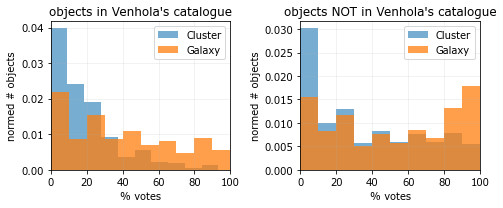

In [14]:
# filter df_votes to only contain objects in the catalogue
in_catalogue = filterby_in_catalogue(df_votes, catalogue_targets, True)
not_in_catalogue = filterby_in_catalogue(df_votes, catalogue_targets, False)

dfs = [in_catalogue, not_in_catalogue]
titles = ["objects in Venhola's catalogue", "objects NOT in Venhola's catalogue"]
make_single_plot_galaxy_cluster(dfs, titles)

- ### Dataframe filtered, considering only users that made at least `n` classifications

In [15]:
# until I've refactored the plotting code below into functions, uncomment either OPTION 1 or OPTION 2

# OPTION 1
# threshold = 500
# df_votes = df_threshold_props

# OR OPTION 2
threshold=0

In [16]:
df_threshold = make_df_vote_threshold(df, threshold)
df_threshold_props = make_df_tasks_with_props(df_threshold, candidate_names_classify, object_info)

first_classifications_per_user = []

# filter first 5 classifications per user
groupby_username = df_threshold.groupby(['user_name'])
for name, classifications in groupby_username:
    group = groupby_username.get_group(name)
    
    for idx, row in group.head().iterrows():
        first_classifications_per_user.append(row['classification_id'])
        
df_threshold_excluded_first = df_threshold[~df_threshold['classification_id'].isin(first_classifications_per_user)]

In [17]:
# list of objects both in catalogue and raw dataframe
objects_in_catalogue_and_spacefluff = list(set(catalogue_targets) & set(df['Filename']))

in_catalogue_and_sf = df_votes[df_votes['name'].isin(objects_in_catalogue_and_spacefluff)]

## Recreate (Venhola2018) fig. 15-17

The below plots are a recreation of figure 15-17 in (Venhola2018), with a distinction made between the objects for which  SpaceFluff volunteers voted strongly in favor of/against seeing a 'galaxy'.

- Plot all objects
- Plot objects with significant number of votes for 'galaxy'
- Plot objects with significant number of votes NOT for 'galaxy'

`@note` we're not strictly just looking for 'galaxy', but specifically for fluffy galaxies, but this is just an initial plot as inspection.

In [18]:
# xlim = [5,25]
xlim = [15,25]

In [19]:
m_r = df_votes['r_mag']
mue_r = df_votes['mue_r']
g = df_votes['g']
r = df_votes['r']
C = df_votes['C']
Reff = df_votes['Reff']

gal = df_votes[df_votes['% votes Galaxy'] > 75]
fluffy = gal[gal['% Fluffy'] > 75]   # can also check just the 'fluffy galaxies' (as voted by the people)
cat_and_fluffy = fluffy[fluffy['name'].isin(objects_in_catalogue_and_spacefluff)]

not_gal = df_votes[df_votes['% votes Galaxy'] < 25]

### Compare objects for which the consensus is 'fluffy' to those 'bright'.

By consensus fluffy, we mean that >=75% of users voted the object to be a galaxy, and of those users, >=75% voted 'fluffy' instead of 'bright'.

In [20]:
consensus_galaxy = df_votes[df_votes['% votes Galaxy'] > 75]
consensus_galaxy_in_catalogue = df_votes.query("(`% votes Galaxy` > 75) and (name.isin(@catalogue_targets))")

consensus_fluffy = cf = consensus_galaxy.query("`% Fluffy` > 75")  # extract objects for which consensus is 'fluffy galaxy', Also define shorthand 'cf'
consensus_bright = cb = consensus_galaxy.query("`% Bright` > 75")

In [90]:
def plot_parameter_histograms(dfs, title, common_args={}, labels=[], savepath=None):
    fig, fr = plt.subplots(1,4, figsize=(16,3.5))
    fr = np.ravel(fr)

    for i, _df in enumerate(dfs):
        label = labels[i] if labels else None
        fr[0].hist(_df['mue_r'], **common_args, label=label)
        fr[1].hist(_df['g']-_df['r'], **common_args, label=label)
        fr[2].hist(_df['C'], **common_args, range=[0,np.max(_df['C'])], label=label)
        fr[3].hist(_df['r_mag'], **common_args, label=label)
        
    fr[0].update({
        'xlabel': r"$\mu_{e,r}$",
        'ylabel': 'Normalized count',
        'xlim': fr[0].get_xlim()[::-1]
    })

    fr[1].update({
        'xlabel': "$g'-r'$",
    })

    fr[2].update({
        'xlabel': 'C',
        'xlim': 0
    })

    fr[3].update({
        'xlabel': "$r'$"
    })

    if labels and len(labels) > 0:
        for i in range(len(fr)):
            fr[i].legend(loc="best", fontsize=8)

    fig.suptitle(title)
    fig.tight_layout()
    
    for i in range(len(fr)):
        fr[i].grid(alpha=0.3, which='both')
        
    if savepath:
        plt.savefig('{}.png'.format(savepath), dpi=350)
    plt.show()

In [76]:
common_args = {
    "density": True,
    "alpha": 0.5,
    "bins": 20,
    "histtype": "stepfilled",
    "edgecolor": "black",
    "linewidth": 1
}

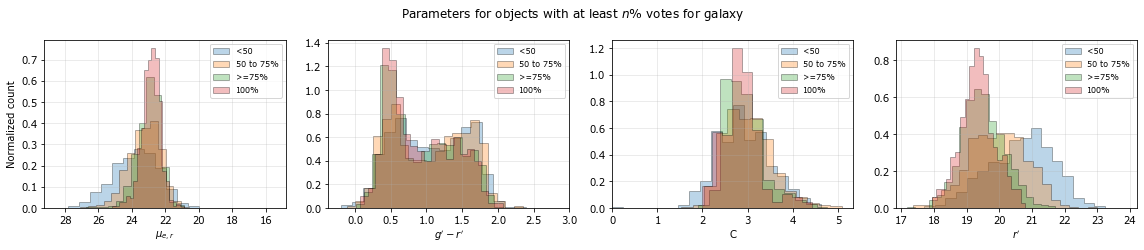

In [91]:
plot_parameter_histograms(
    dfs=[
        df_votes.query("`% votes Galaxy` <= 50"),
        df_votes.query("(`% votes Galaxy` > 50) & (`% votes Galaxy` < 75)"),
        df_votes.query("`% votes Galaxy` >= 75"),
        df_votes.query("`% votes Galaxy` == 100")
    ], 
    labels=['<50', '50 to 75%', '>=75%', '100%'], 
    title='Parameters for objects with at least $n$% votes for galaxy', 
    common_args={**common_args, "alpha": 0.3},
    savepath="consensus galaxy histograms binned"
)

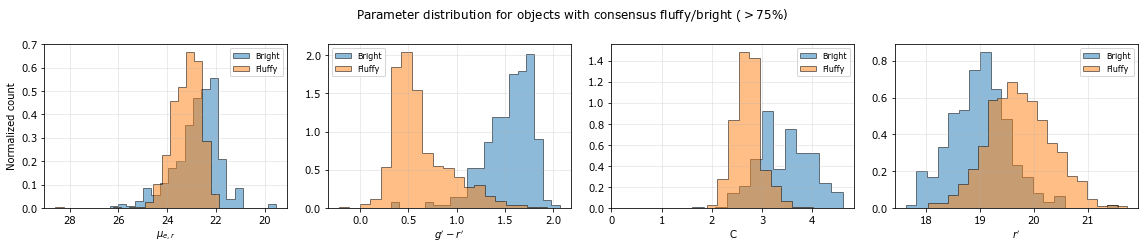

In [93]:
consensus = [consensus_bright, consensus_fluffy]
consensus_labels = ['Bright', 'Fluffy']

plot_parameter_histograms(
    dfs=consensus, 
    labels=consensus_labels, 
    title=r'Parameter distribution for objects with consensus fluffy/bright ($>75\%)$', 
    common_args=common_args,
    savepath='gal fluffy vs bright'
)

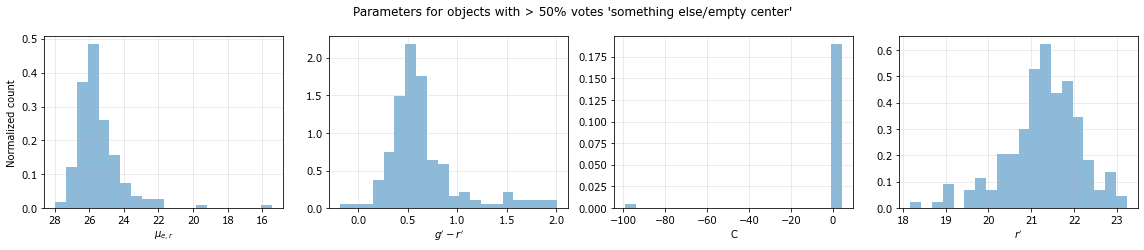

In [25]:
plot_parameter_histograms(
    dfs=[df_votes.query('`% votes Something else/empty center` > 50')], 
    title='Parameters for objects with > 50% votes \'something else/empty center\'',
    common_args=common_args
)

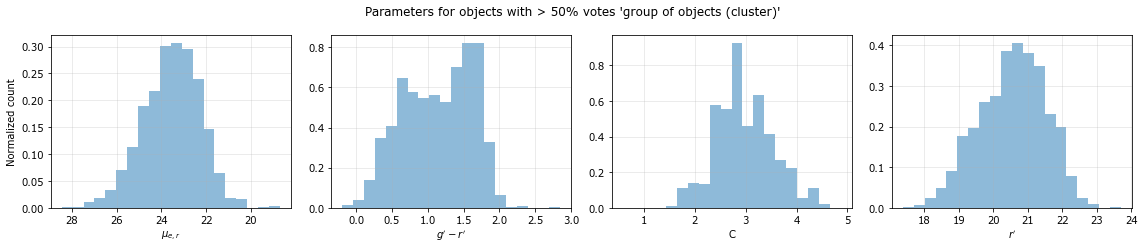

In [26]:
plot_parameter_histograms(
    dfs=[df_votes.query('`% votes Group of objects (Cluster)` > 50')], 
    title='Parameters for objects with > 50% votes \'group of objects (cluster)\'',
    common_args=common_args
)

In [124]:
def plot_fluffy_vs_bright(dfs, title, labels, savepath=None):
    fig, fr = plt.subplots(1,4, figsize=(12,3))
    fr = np.ravel(fr)

    markers = ['o', 'D', 'v', 'd']
    
    common_args = {
        'alpha': 0.3,
        's': 7,
    }

    for i, _df in enumerate(dfs):
        fr[0].scatter(_df['r_mag'], _df['mue_r'], **common_args, marker=markers[i], label=labels[i])
        fr[1].scatter(_df['r_mag'], _df['g']-_df['r'], **common_args, marker=markers[i], label=labels[i])
        fr[2].scatter(_df['r_mag'], _df['C'], **common_args, marker=markers[i],  label=labels[i])
        fr[3].scatter(_df['g']-_df['r'], _df['mue_r'], **common_args, marker=markers[i], label=labels[i])

    fr[0].update({
        'xlabel': "$r'$",
        'ylabel': r"$\mu_{e,r}$",
        'ylim': fr[0].get_ylim()[::-1]
    })

    fr[1].update({
        'xlabel': "$r'$",
        'ylabel': "$g'-r'$"
    })

    fr[2].update({
        'xlabel': "$r'$",
        'ylabel': '$C$',
        'ylim': [1, 0.5+max([_df['C'].max() for _df in dfs])]
    })

    fr[3].update({
        'xlabel': r"$g'-r'$",
        'ylabel': r"$\mu_{e,r}$",
        'ylim': fr[3].get_ylim()[::-1]
    })

    for i in range(len(fr)):
        fr[i].grid(alpha=0.3, which='both')
    
#     fr[0].legend(loc="lower left", bbox_to_anchor=(0, -0.5), ncol=1, fancybox=True)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    fig.legend(
        *zip(*unique), 
        loc="lower left", 
        bbox_to_anchor=(0.03, 0.83), 
        ncol=len(labels), 
#         fancybox=True,
    )

    fig.suptitle(title)
    fig.tight_layout()
#     plt.savefig('./plots/parameters/{}.png'.format(datetime.strftime(datetime.now(), '%y-%m-%d %H-%M-%S')), dpi=250, bbox_inches='tight')
    if savepath:
        plt.savefig('{}.png'.format(savepath), dpi=350, bbox_inches='tight')
    plt.show()

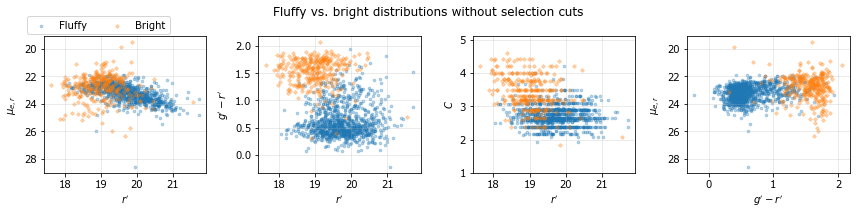

In [125]:
plot_fluffy_vs_bright([cf, cb], 'Fluffy vs. bright distributions without selection cuts', ['Fluffy', 'Bright'], 'venhola fluffy vs bright, no cuts')

Attempt to manually perform the selection cuts as presented in (Venhola2018):
- color cut: exclude objects redder than brightest spectroscopically confirmed cluster galaxies, i.e. those where $g'-r' > 0.95$, and $g'-i' > 1.35$
- `@todo`: surface brightness cut: make linear fit in magnitude-surface brightness space, exclude galaxies with surface brightness more than 3 standard deviations from the fit.
- `@todo`: concentration cut: (Venhola2018) fits the magnitude-C relation for $m_{r'} < 16$ mag, and simply excludes objects with $C > 3.5$ if $m_{r'} > 16$. We don't have any objects of $m_{r'} < 16$, so we can simply exclude all objects with $C > 3.5$.

In [29]:
colorcut_query = '(g-r < 0.95) and (g-i < 1.35)'
cf_colorcut = cf.query(colorcut_query)
cb_colorcut = cb.query(colorcut_query)

In [30]:
print(cf.shape[0], cb.shape[0])
print(cf_colorcut.shape[0], cb_colorcut.shape[0])

1008 308
809 4


Making this selection cut removes almost all 'consensus bright galaxy' objects, which indicates that the people are quite accurate at identifying this type of galaxy. Unfortunately for the project, this color cut is made to exclude what are believed to be background galaxies, so the people's accuracy here doesn't necessarily help us in achieving the goal of identifying the fluffy galaxies.

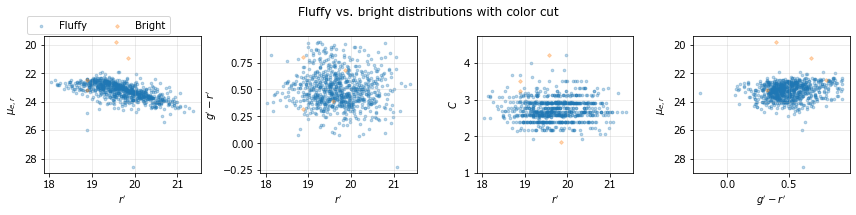

In [127]:
plot_fluffy_vs_bright([cf_colorcut, cb_colorcut], 'Fluffy vs. bright distributions with color cut', ['Fluffy', 'Bright'], savepath="venhola fluffy vs bright colorcut")

In [32]:
def get_fit_value(x, n):
    return n[1] + x*n[0]

get_fit_values = np.vectorize(get_fit_value, excluded=["n"])

def deviation_from_linear_fit(x, y):
    '''
        Find deviation of a value from the linear fit of the dataset from which said value originates.
        @params x, y x- and y-values of the data point
        @note n is the result of a linear regression using np.polyfit(deg=1)
    '''
    fit_value = get_fit_value(x, n)
    return (fit_value-y)**2

In [33]:
# create single df out of the fluffy and bright dataframes post-color cut
colorcut = cf_colorcut.append(cb_colorcut)

# perform a linear fit on the combined dataframe
n = np.polyfit(colorcut['r_mag'], colorcut['mue_r'], 1)

xs = np.linspace(colorcut['r_mag'].min(), colorcut['r_mag'].max(), int(1e5))
ys = get_fit_values(x=xs, n=n)

# determine the variation and standard deviation from the fit:
deviations = np.vectorize(deviation_from_linear_fit)(colorcut['r_mag'], colorcut['mue_r'])

if (colorcut['r_mag'].shape[0] == colorcut['mue_r'].shape[0]):  # ensure dimensions of x and y are equal, otherwise something went wrong in df creation
    N = colorcut['r_mag'].shape[0]
    sigma = np.sqrt(np.sum(deviations)/(N-1))

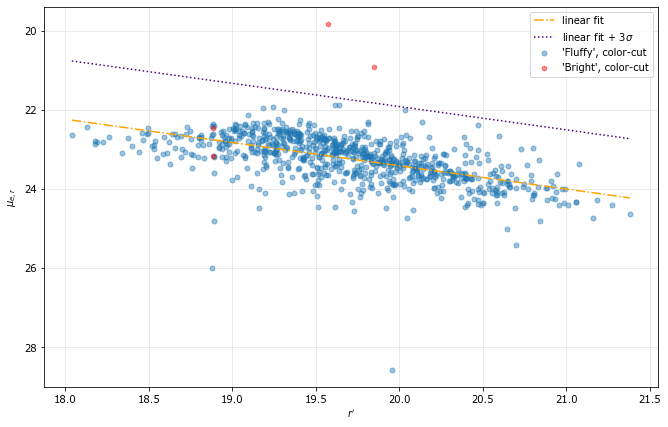

In [132]:
common_props = {
    "s": 25,
    "alpha": 0.45,
}

# plot the data
fig, fr = plt.subplots(figsize=(11,7))
s1 = fr.scatter(cf_colorcut['r_mag'], cf_colorcut['mue_r'], **common_props, c='#1f77b4', marker="o", label='\'Fluffy\', color-cut')
s2 = fr.scatter(cb_colorcut['r_mag'], cb_colorcut['mue_r'], **common_props, c='red', marker='h', label='\'Bright\', color-cut')
# fr.scatter(in_catalogue['r_mag'], in_catalogue['mue_r'], c="black", s=20, alpha=0.4, marker="D")

# also plot the linear fit
xs = np.linspace(colorcut['r_mag'].min(), colorcut['r_mag'].max(), int(1e5))
ys = n[1]+xs*n[0]
fr.plot(xs, ys, c='orange', ls='-.', label='linear fit')
fr.plot(xs, ys-3*sigma, ls=':', label=r'linear fit + $3\sigma$', c='indigo')

fr.update({
    'xlabel': "$r'$",
    'ylabel': r"$\mu_{e,r}$",
    'ylim': fr.get_ylim()[::-1]
})
legend_grid_show(fr, savepath="venhola fluffy vs bright sb cut")

Above, we see that performing the surface brightness selection cut excludes none of the 'consensus fluffy' objects, but does exclude 'consensus bright' galaxies.

In [35]:
def surface_brightness_cutoff(x, y, sigma):
    '''
        Performs surface-brightness cutoff based on linear fit. Exclude objects at least 3\sigma above brighter than the linear fit.
        @params x, y: x and y values of the data point
        @param sigma: standard deviation w.r.t. linear fit
    '''

    return y < (get_fit_value(x,n)-3*sigma)

surface_brightness_cutoff = np.vectorize(surface_brightness_cutoff)
excluded = surface_brightness_cutoff(colorcut['r_mag'], colorcut['mue_r'], sigma)
cut_off_by_surface_brightness = colorcut.iloc[np.where(excluded)]
surface_brightness_cut = colorcut[~colorcut.index.isin(colorcut.index[excluded])]

In [36]:
final_cut = surface_brightness_cut[surface_brightness_cut['C'] <= 3.5]

## Now we've made our own selection cuts, we can again overplot various dataframes to see if we can find any patterns.

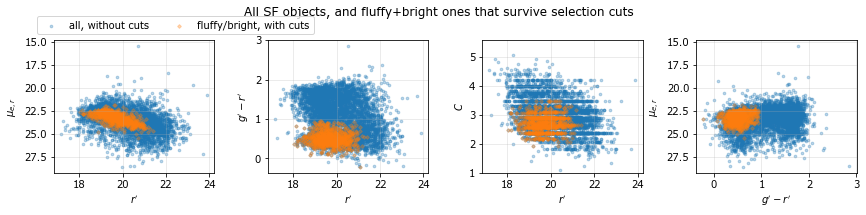

In [133]:
plot_fluffy_vs_bright(
    [df_votes, final_cut], 
    'All SF objects, and fluffy+bright ones that survive selection cuts', 
    ['all, without cuts', 'fluffy/bright, with cuts']
)

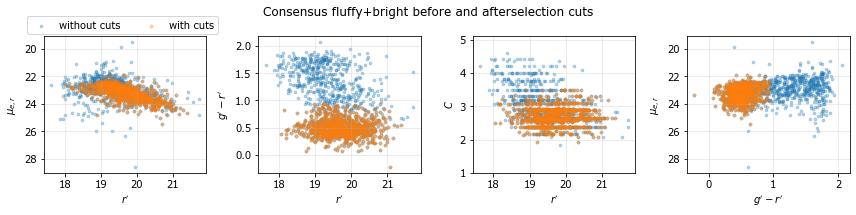

In [135]:
plot_fluffy_vs_bright(
    [cf.append(cb), final_cut], 
    'Consensus fluffy+bright before and afterselection cuts', 
    ['without cuts', 'with cuts'],
    savepath="venhola fluffy vs bright before after cuts"
)

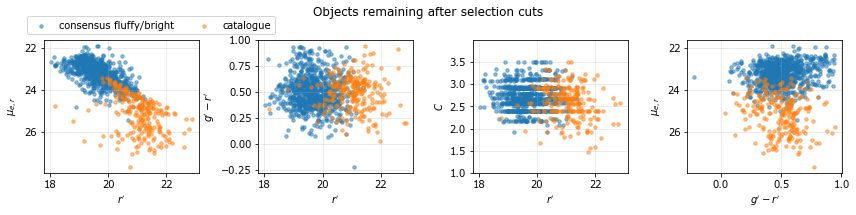

In [39]:
plot_fluffy_vs_bright(
    [final_cut, in_catalogue], 
    'Objects remaining after selection cuts', 
    ['consensus fluffy/bright', 'catalogue'],
    
)

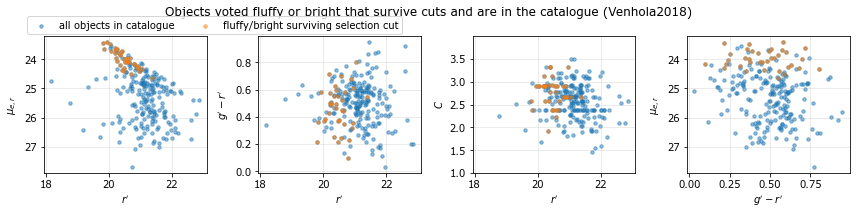

In [40]:
intersection = list(set(final_cut['name']) & set(in_catalogue['name']))

plot_fluffy_vs_bright(
    dfs=[
            in_catalogue,
            df_votes.query('name.isin(@intersection)')
        ],
    title="Objects voted fluffy or bright that survive cuts and are in the catalogue (Venhola2018)",
    labels=[
        'all objects in catalogue',
        'fluffy/bright surviving selection cut'
    ]
)

In [41]:
# for i in range(len(answers)):
#     plot_fluffy_vs_bright(
#         dfs=[
#             df_votes,
#             df_votes.query("`{}` > 50".format(answers)),
#         ],
#         title="Objects with >50% of vote for '{}'".format(answers),
#         labels=[
#             'all SpaceFluff objects',
#             "'{}' >50%".format(answers)
#         ]
#     )

### Compare other properties of objects between SpaceFluff and the selective catalogue to see if we can make any further distinctions based on properties

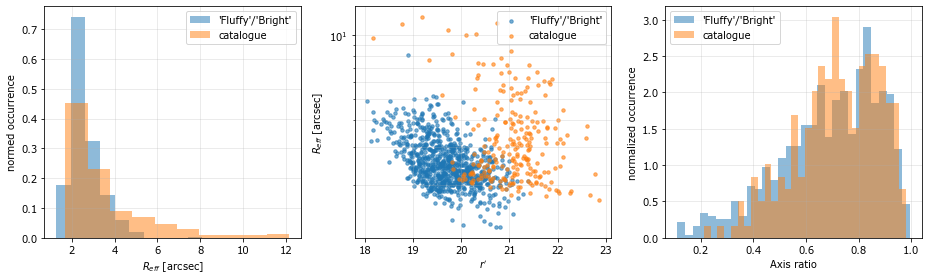

In [42]:
fig, fr = plt.subplots(1,3, figsize=(13,4))

common_props = {
    'alpha': 0.5,
    'density': True,
}

common_scatter = {
    "alpha": 0.6,
    "s": 12
}

for idx, (_df, label) in enumerate(zip([final_cut, in_catalogue], ["'Fluffy'/'Bright'", 'catalogue'])):

    fr[0].hist(_df['Reff'], **common_props, label=label)
    fr[1].scatter(_df['r_mag'], _df['Reff'], **common_scatter, label=label)
    fr[2].hist(_df['axis_ratio'], **common_props, label=label, bins=30)

fr[0].update({
    'xlabel': r'$R_{eff}$ [arcsec]',
    'ylabel': 'normed occurrence'
})

fr[1].update({
    'yscale': 'log',
    'xlabel': r"$r'$",
    'ylabel': r'$R_{eff}$ [arcsec]',
})

fr[2].update({
    'xlabel': 'Axis ratio',
    'ylabel': 'normalized occurrence'
})

for i in range(len(fr)):
    fr[i].legend()
    fr[i].grid(alpha=0.3, which='both')

fig.tight_layout()

plt.show()

In [43]:
df['T1'].unique()

array([None, 'Bright', 'Fluffy'], dtype=object)

In [44]:
ra_dec = df_votes.query("name.isin(@catalogue_targets)").head(10)[['RA', 'DEC']].values
for (ra, dec) in ra_dec:
    print('{} {}'.format(ra, dec))

51.65265274047852 -35.02645874023437
53.56597137451172 -35.65239715576172
54.5273551940918 -34.415027618408196
56.09554290771485 -34.62240600585937
52.37764358520508 -34.40242385864258
53.87986755371094 -37.039459228515625
54.07341384887695 -34.31870651245117
51.639137268066406 -35.15436172485352
56.54578018188477 -34.352806091308594
56.70469284057617 -34.77948760986328


In [45]:
ra_dec = final_cut[['RA', 'DEC']].values
final_cut.head(10)

,name,% Fluffy,% Bright,% None,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center,RA,...,ge,re,ie,Reffe,r_mage,ne,C,mue_r,bae,RFF
16,UDGcand_1489,100.0,0.0,0.0,"{'Galaxy': 13, 'Group of objects (Cluster)': 1...",15.0,86.7,6.7,6.7,55.325653,...,0.041086,0.035513,0.040888,0.264910,0.095337,0.091208,2.218488,22.986864,0.021387,-99.0
17,UDGcand_2109,100.0,0.0,0.0,"{'Galaxy': 13, 'Something else/empty center': 2}",15.0,86.7,0.0,13.3,54.316422,...,0.065536,0.053250,0.047229,0.367784,0.161969,0.138003,2.764210,23.977282,0.032067,-99.0
37,UDGcand_4204,83.3,16.7,0.0,"{'Galaxy': 12, 'Something else/empty center': ...",15.0,80.0,13.3,6.7,53.394032,...,0.042882,0.035736,0.040647,0.124308,0.074589,0.075292,2.657395,22.528238,0.017730,-99.0
41,UDGcand_141,100.0,0.0,0.0,"{'Galaxy': 12, 'Something else/empty center': 1}",13.0,92.3,0.0,7.7,55.574390,...,0.133566,0.093352,0.067742,0.852870,0.280996,0.212251,2.685596,25.006834,0.048854,-99.0
48,UDGcand_4557,100.0,0.0,0.0,"{'Galaxy': 13, 'Group of objects (Cluster)': 1...",15.0,86.7,6.7,6.7,54.441738,...,0.083716,0.064227,0.046375,0.238065,0.165390,0.140275,2.657395,24.016338,0.032583,-99.0
52,UDGcand_864,80.0,20.0,0.0,{'Galaxy': 15},15.0,100.0,0.0,0.0,53.630733,...,0.054420,0.046552,0.043467,0.231915,0.116881,0.106948,2.168278,23.367601,0.024991,-99.0
58,UDGcand_505,91.7,0.0,8.3,"{'Galaxy': 12, 'Group of objects (Cluster)': 1}",13.0,92.3,7.7,0.0,55.665894,...,0.049508,0.043237,0.042914,0.246428,0.114986,0.105591,3.494850,23.337055,0.024680,-99.0
79,UDGcand_948,92.3,7.7,0.0,"{'Galaxy': 13, 'Something else/empty center': ...",15.0,86.7,6.7,6.7,53.565971,...,0.072202,0.055558,0.049257,0.362439,0.169538,0.143016,2.583149,24.062624,0.033206,-99.0
83,UDGcand_2439,84.6,15.4,0.0,"{'Galaxy': 13, 'Group of objects (Cluster)': 1...",15.0,86.7,6.7,6.7,52.905426,...,0.053147,0.044641,0.043312,0.264844,0.081389,0.080604,2.634045,22.691277,0.018952,-99.0
109,UDGcand_1638,85.7,14.3,0.0,"{'Galaxy': 14, 'Something else/empty center': 1}",15.0,93.3,0.0,6.7,50.465439,...,0.050279,0.040803,0.042810,0.423164,0.124208,0.112152,2.821357,23.481232,0.026179,-99.0


In [46]:
# for (ra, dec) in ra_dec[:100]:
#     print('{},{}'.format(ra, dec))

In [47]:
# sorted(list(map(lambda x: int(x[8:]), list(df['Filename'].unique()))))

In [48]:
df['Filename'].unique().shape[0]

6362

## (for thesis): objects in catalogue and fluffies surviving selection cut

In [140]:
# in_catalogue,
final_cut
# df_votes.query('name.isin(@intersection)')

,name,% Fluffy,% Bright,% None,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center,RA,...,ge,re,ie,Reffe,r_mage,ne,C,mue_r,bae,RFF
16,UDGcand_1489,100.0,0.0,0.0,"{'Galaxy': 13, 'Group of objects (Cluster)': 1...",15.0,86.7,6.7,6.7,55.325653,...,0.041086,0.035513,0.040888,0.264910,0.095337,0.091208,2.218488,22.986864,0.021387,-99.0
17,UDGcand_2109,100.0,0.0,0.0,"{'Galaxy': 13, 'Something else/empty center': 2}",15.0,86.7,0.0,13.3,54.316422,...,0.065536,0.053250,0.047229,0.367784,0.161969,0.138003,2.764210,23.977282,0.032067,-99.0
37,UDGcand_4204,83.3,16.7,0.0,"{'Galaxy': 12, 'Something else/empty center': ...",15.0,80.0,13.3,6.7,53.394032,...,0.042882,0.035736,0.040647,0.124308,0.074589,0.075292,2.657395,22.528238,0.017730,-99.0
41,UDGcand_141,100.0,0.0,0.0,"{'Galaxy': 12, 'Something else/empty center': 1}",13.0,92.3,0.0,7.7,55.574390,...,0.133566,0.093352,0.067742,0.852870,0.280996,0.212251,2.685596,25.006834,0.048854,-99.0
48,UDGcand_4557,100.0,0.0,0.0,"{'Galaxy': 13, 'Group of objects (Cluster)': 1...",15.0,86.7,6.7,6.7,54.441738,...,0.083716,0.064227,0.046375,0.238065,0.165390,0.140275,2.657395,24.016338,0.032583,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5858,UDGcand_5263,84.6,15.4,0.0,"{'Galaxy': 13, 'Group of objects (Cluster)': 1...",15.0,86.7,6.7,6.7,52.361217,...,0.065699,0.051270,0.044892,0.278612,0.143773,0.125732,3.116246,23.754580,0.029275,-99.0
5862,UDGcand_482,93.3,6.7,0.0,{'Galaxy': 15},15.0,100.0,0.0,0.0,55.708458,...,0.052426,0.043713,0.042699,0.168518,0.104302,0.097844,2.657395,23.154821,0.022908,-99.0
5873,UDGcand_4697,78.6,21.4,0.0,"{'Galaxy': 14, 'Group of objects (Cluster)': 1}",15.0,93.3,6.7,0.0,54.872566,...,0.054375,0.045096,0.042381,0.297958,0.124671,0.112478,2.764210,23.488176,0.026254,-99.0
854,UDGcand_2058,23.1,76.9,0.0,"{'Galaxy': 13, 'Group of objects (Cluster)': 2}",15.0,86.7,13.3,0.0,54.257092,...,0.038983,0.036249,0.041332,0.282790,0.104882,0.098269,3.494850,23.165188,0.023005,-99.0
